In [1]:
import pandas as pd
import maidenhead as mh
import numpy as np

# Define some constants
SILVER_IN_PATH = '/usr/datalake/silver/stormevents/csvfiles/severe_records.csv'
SILVER_OUT_PATH = '/usr/datalake/silver/stormevents/csvfiles/severe_maidenhead.csv'
use_columns = ['EFFECTIVE', 'BEGIN_LAT', 'BEGIN_LON', 'TORNADO_MINOR', 'TORNADO_SIGNIFICANT', 'HAIL_MINOR', 'HAIL_SIGNIFICANT', 'WIND_MINOR','WIND_SIGNIFICANT']

In [2]:
def effective_filter(original_df: pd.DataFrame) -> pd.DataFrame:
    result = original_df.copy()
    result['EFFECTIVE'] = pd.to_datetime(result['EFFECTIVE'])
    result = result[(result['EFFECTIVE'].dt.hour < 20) & (result['EFFECTIVE'].dt.hour > 13)]
    result['EFFECTIVE'] = result['EFFECTIVE'].dt.date

    return result

def add_severe_significant(original_df: pd.DataFrame) -> pd.DataFrame:
    result = original_df.copy()
    result['SEVERE_SIGNIFICANT'] = np.minimum(result['TORNADO_SIGNIFICANT'] + result['HAIL_SIGNIFICANT'] + result['WIND_SIGNIFICANT'], 1)
    result = result.drop(['TORNADO_SIGNIFICANT', 'HAIL_SIGNIFICANT', 'WIND_SIGNIFICANT'], axis=1)

    return result

def add_severe_minor(original_df: pd.DataFrame) -> pd.DataFrame:
    result = original_df.copy()
    result['SEVERE_MINOR'] = np.minimum(result['TORNADO_MINOR'] + result['HAIL_MINOR'] + result['WIND_MINOR'], 1)
    result = result.drop(['TORNADO_MINOR', 'HAIL_MINOR', 'WIND_MINOR'], axis=1)

    return result

def add_maidenhead(original_df: pd.DataFrame) -> pd.DataFrame:
    result = original_df.copy()
    result['MAIDENHEAD'] = result.apply(lambda x: mh.to_maiden(x.BEGIN_LAT, x.BEGIN_LON, 2), axis=1)
    result = result.drop(labels=['BEGIN_LAT', 'BEGIN_LON'], axis=1)

    return result

def groupby_date_maidenhead(original_df: pd.DataFrame) -> pd.DataFrame:
    result = original_df.copy()
    result = result.groupby(['EFFECTIVE', 'MAIDENHEAD']).max()
    
    return result

def cascade_severity(original_df: pd.DataFrame) -> pd.DataFrame:
    result = original_df.copy()
    result.loc[result['SEVERE_SIGNIFICANT'] == 1, 'SEVERE_MINOR'] = 0

    return result

In [3]:
df = pd.read_csv(SILVER_IN_PATH, usecols=use_columns)
df = effective_filter(df)
df = add_severe_significant(df)
df = add_severe_minor(df)
df = add_maidenhead(df)
df = groupby_date_maidenhead(df)
df = cascade_severity(df)
df.head()

SEVERE_SIGNIFICANT  SEVERE_MINOR
EFFECTIVE  MAIDENHEAD                                  
1990-01-02 DM42                         0             1
1990-01-03 EM06                         0             1
           EM12                         0             1
           EM16                         0             1
1990-01-16 EM04                         0             1

In [4]:
df.shape

(130335, 2)

In [5]:
df.to_csv(SILVER_OUT_PATH)

<Axes: xlabel='Rating'>

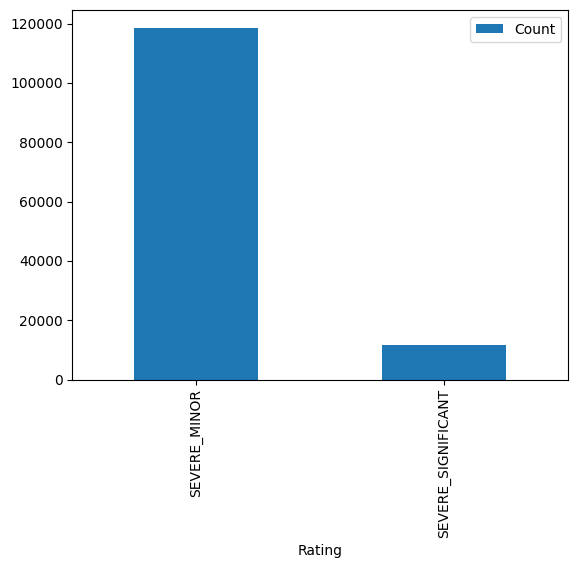

In [9]:
hist_df = pd.DataFrame(df[['SEVERE_MINOR', 'SEVERE_SIGNIFICANT']].sum(), columns=['Count'])
hist_df.index.name = 'Rating'
hist_df.plot(kind='bar')